In [ ]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import RMSprop,Adam

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [ ]:
data_dir = 'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data'  

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


Found 17353 files belonging to 2 classes.
Train samples:      1068     batches(13) ==> 13884
Validation samples: 200       batches(13) ==> 2600
Test samples:       67      batches(13) ==> 871


In [ ]:

def model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [ ]:
model = model()

model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])  # Compile the model
# model.summary()

In [ ]:
history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

Epoch 1/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 30145s 29s/step - accuracy: 0.6740 - loss: 0.6215 - precision: 0.6740 - recall: 0.6740 - val_accuracy: 0.8426 - val_loss: 0.3501 - val_precision: 0.8426 - val_recall: 0.8426
Epoch 2/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 3384s 3s/step - accuracy: 0.8562 - loss: 0.3268 - precision: 0.8562 - recall: 0.8562 - val_accuracy: 0.8862 - val_loss: 0.3286 - val_precision: 0.8862 - val_recall: 0.8862
Epoch 3/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 2398s 2s/step - accuracy: 0.9336 - loss: 0.1730 - precision: 0.9336 - recall: 0.9336 - val_accuracy: 0.9352 - val_loss: 0.1919 - val_precision: 0.9352 - val_recall: 0.9352
Epoch 4/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 2779s 3s/step - accuracy: 0.9620 - loss: 0.1081 - precision: 0.9620 - recall: 0.9620 - val_accuracy: 0.9278 - val_loss: 0.2110 - val_precision: 0.9278 - val_recall: 0.9278
Epoch 5/7
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 3256s 3s/step - accuracy: 0.9713 - loss: 0.0841 - precision: 0.9713 - recall: 0.9713 - val_accuracy: 0.94

In [ ]:
model.save("trained_model/ResNet50.keras")

In [ ]:
# Define the second model with adjusted hyperparameters
def model_v2():
    base_model_v2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model_v2.layers:
        layer.trainable = False

    # Unfreeze 60% of layers instead of 50%
    from_index_v2 = int(np.round((len(base_model_v2.layers) - 1) * (1.0 - 60.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model_v2.layers[from_index_v2:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x_v2 = base_model_v2.output
    x_v2 = GlobalAveragePooling2D()(x_v2)
    x_v2 = Dense(512, activation='relu')(x_v2)  # Reduced Dense layer size from 1024 to 512
    x_v2 = Dropout(0.3)(x_v2)  # Lowered dropout rate from 0.5 to 0.3
    predictions_v2 = Dense(2, activation='softmax')(x_v2)  # Assuming binary classification

    model_v2 = Model(inputs=base_model_v2.input, outputs=predictions_v2)
    
    return model_v2

# Create and compile the second model
model_v2 = model_v2()
model_v2.compile(optimizer=Adam(learning_rate=5e-5),  # Adjusted learning rate to 5e-5
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(name='precision_v2'), Recall(name='recall_v2')])


In [ ]:
# Train the second model
history_v2 = model_v2.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

# Summarize the second model
model_v2.summary()

Epoch 1/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2795s 3s/step - accuracy: 0.7047 - loss: 0.5707 - precision_v2: 0.7047 - recall_v2: 0.7047 - val_accuracy: 0.8565 - val_loss: 0.3362 - val_precision_v2: 0.8565 - val_recall_v2: 0.8565
Epoch 2/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2532s 2s/step - accuracy: 0.9062 - loss: 0.2345 - precision_v2: 0.9062 - recall_v2: 0.9062 - val_accuracy: 0.7823 - val_loss: 0.6542 - val_precision_v2: 0.7823 - val_recall_v2: 0.7823
Epoch 3/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2229s 2s/step - accuracy: 0.9574 - loss: 0.1198 - precision_v2: 0.9574 - recall_v2: 0.9574 - val_accuracy: 0.9000 - val_loss: 0.3064 - val_precision_v2: 0.9000 - val_recall_v2: 0.9000
Epoch 4/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 1722s 2s/step - accuracy: 0.9683 - loss: 0.0902 - precision_v2: 0.9683 - recall_v2: 0.9683 - val_accuracy: 0.9165 - val_loss: 0.3094 - val_precision_v2: 0.9165 - val_recall_v2: 0.9165
Epoch 5/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2734s 3s/step - accuracy: 0.9734 - loss: 0.0748 - precision

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 71,468,936 (272.63 MB)

 Trainable params: 23,415,554 (89.32 MB)

 Non-trainable params: 1,222,272 (4.66 MB)

 Optimizer params: 46,831,110 (178.65 MB)

In [ ]:
model_v2.save("trained_model/ResNet50_v2.keras")

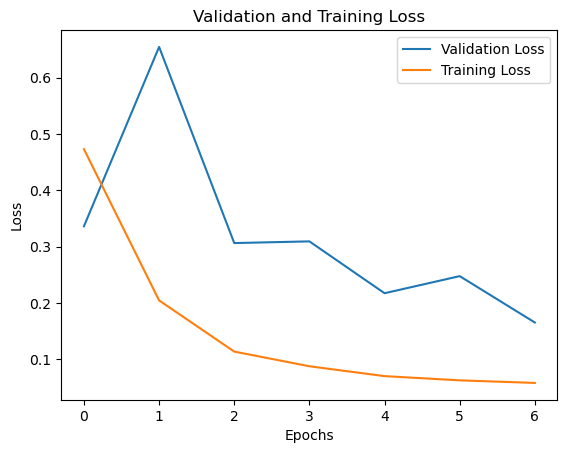

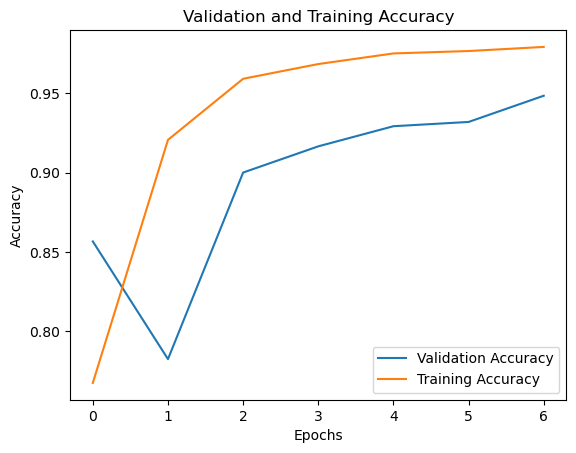

In [ ]:
# Plot the validation loss
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

# Define the third model with different hyperparameters
def model_v3():
    base_model_v3 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model_v3.layers:
        layer.trainable = False

    # Unfreeze 70% of layers (more layers unfreezed compared to v1 and v2)
    from_index_v3 = int(np.round((len(base_model_v3.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model_v3.layers[from_index_v3:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x_v3 = base_model_v3.output
    x_v3 = GlobalAveragePooling2D()(x_v3)
    x_v3 = Dense(1024, activation='relu')(x_v3)  # Return Dense layer size to 1024
    x_v3 = Dropout(0.4)(x_v3)  # Moderate dropout rate (between v1 and v2)
    predictions_v3 = Dense(2, activation='softmax')(x_v3)  # Assuming binary classification

    model_v3 = Model(inputs=base_model_v3.input, outputs=predictions_v3)
    
    return model_v3

# Create and compile the third model
model_v3 = model_v3()
model_v3.compile(optimizer=RMSprop(learning_rate=1e-4),  # Change optimizer to RMSprop and learning rate back to 1e-4
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(name='precision_v3'), Recall(name='recall_v3')])



In [ ]:
# Train the third model
history_v3 = model_v3.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=13,
            epochs=7
        )

# Summarize the third model
model_v3.summary()

Epoch 1/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2801s 3s/step - accuracy: 0.6875 - loss: 0.6376 - precision_v3: 0.6875 - recall_v3: 0.6875 - val_accuracy: 0.8104 - val_loss: 0.6151 - val_precision_v3: 0.8104 - val_recall_v3: 0.8104
Epoch 2/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3355s 3s/step - accuracy: 0.8634 - loss: 0.3317 - precision_v3: 0.8634 - recall_v3: 0.8634 - val_accuracy: 0.8942 - val_loss: 0.3199 - val_precision_v3: 0.8942 - val_recall_v3: 0.8942
Epoch 3/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2313s 2s/step - accuracy: 0.9429 - loss: 0.1572 - precision_v3: 0.9429 - recall_v3: 0.9429 - val_accuracy: 0.9104 - val_loss: 0.4047 - val_precision_v3: 0.9104 - val_recall_v3: 0.9104
Epoch 4/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2357s 2s/step - accuracy: 0.9652 - loss: 0.1108 - precision_v3: 0.9652 - recall_v3: 0.9652 - val_accuracy: 0.9131 - val_loss: 0.3069 - val_precision_v3: 0.9131 - val_recall_v3: 0.9131
Epoch 5/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2130s 2s/step - accuracy: 0.9686 - loss: 0.0958 - precision

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 50,649,606 (193.21 MB)

 Trainable params: 24,961,666 (95.22 MB)

 Non-trainable params: 726,272 (2.77 MB)

 Optimizer params: 24,961,668 (95.22 MB)

In [ ]:
model_v3.save("trained_model/ResNet50_v3.keras")